In [1]:
# set os at top 
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ['HF_HOME'] = '/data1/wln/hf_cache'

import torch
from peft import PeftModel
from transformers import AutoProcessor, Blip2ForConditionalGeneration

# Load base model
base_model = Blip2ForConditionalGeneration.from_pretrained(
    'Salesforce/blip2-opt-2.7b', 
    local_files_only=True,
) 

# Load LoRA adapter
lora_model = PeftModel.from_pretrained(base_model, "lora_adapter_loss_5_03101757")

# Load tokenizer
processor = AutoProcessor.from_pretrained('Salesforce/blip2-opt-2.7b')


/data1/wln/miniconda3/envs/llm-pbe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


Dataset({
    features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
    num_rows: 245
})


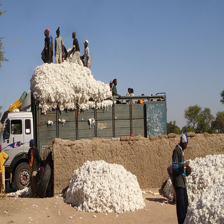

Sample 1: A man are a a a a a a a a of a a pile a a... of.................
A group of people stand in the back of a truck filled with cotton.


In [5]:
from datasets import load_from_disk
from PIL import Image
from IPython.display import display
device = "cuda" if torch.cuda.is_available() else "cpu"
instruct = "A short image caption:"

val_ds = load_from_disk("../dataset/val_dataset")
print(val_ds)

lora_model=lora_model.to(device)
lora_model.eval()
for index, item in enumerate(val_ds):
    if index==1:
        break
    encoding = processor(
        images = item['image'],
        text=instruct,
        return_tensors='pt'
    )
     # Move inputs to the correct device
    input_ids = encoding["input_ids"].to(device)
    pixel_values = encoding["pixel_values"].to(device)

    with torch.no_grad():
        outputs = lora_model(
            input_ids = input_ids,
            pixel_values = pixel_values
        )
    # Decode generated text
    generated_text = processor.tokenizer.decode(outputs.logits.argmax(dim=-1)[0], skip_special_tokens=True)
    
    image = item['image'].convert('RGB')
    display(image.resize((224,224)))
    print(f"Sample {index + 1}: {generated_text}")
    print(item['caption'][0])

